In [3]:
import os
import numpy as np

def generate_effective_connectivity_matrix(size, density=0.5, weight_range=(-1, 1)):
    min_weight, max_weight = weight_range
    weights = np.random.uniform(min_weight, max_weight, size=(size, size))
    mask = np.random.rand(size, size) < density
    weights *= mask
    return weights

# Parameters
num_subjects = 10
matrix_size = 70
matrix_density = 0.4
weight_range = (-1, 1)

# Create a folder for subjects
if not os.path.exists("subject_matrices"):
    os.makedirs("subject_matrices")

# Generate effective connectivity matrices for multiple subjects
subject_matrices = []
for subject_idx in range(num_subjects):
    connectivity_matrix = generate_effective_connectivity_matrix(matrix_size, matrix_density, weight_range)
    subject_matrices.append(connectivity_matrix)
    subject_folder = os.path.join("subject_matrices", f"subject_{subject_idx + 1}")
    
    if not os.path.exists(subject_folder):
        os.makedirs(subject_folder)
    
    matrix_filename = os.path.join(subject_folder, f"matrix_subject_{subject_idx + 1}.txt")
    np.savetxt(matrix_filename, connectivity_matrix)
    
    print(f"Matrix for Subject {subject_idx + 1} saved to: {matrix_filename}")

# Combine matrices into a 3D array
combined_matrix = np.stack(subject_matrices, axis=2)

# Save the combined matrix
np.save("combined_matrix.npy", combined_matrix)
print("Combined matrix saved as 'combined_matrix.npy'")


Matrix for Subject 1 saved to: subject_matrices/subject_1/matrix_subject_1.txt
Matrix for Subject 2 saved to: subject_matrices/subject_2/matrix_subject_2.txt
Matrix for Subject 3 saved to: subject_matrices/subject_3/matrix_subject_3.txt
Matrix for Subject 4 saved to: subject_matrices/subject_4/matrix_subject_4.txt
Matrix for Subject 5 saved to: subject_matrices/subject_5/matrix_subject_5.txt
Matrix for Subject 6 saved to: subject_matrices/subject_6/matrix_subject_6.txt
Matrix for Subject 7 saved to: subject_matrices/subject_7/matrix_subject_7.txt
Matrix for Subject 8 saved to: subject_matrices/subject_8/matrix_subject_8.txt
Matrix for Subject 9 saved to: subject_matrices/subject_9/matrix_subject_9.txt
Matrix for Subject 10 saved to: subject_matrices/subject_10/matrix_subject_10.txt
Combined matrix saved as 'combined_matrix.npy'


In [7]:
import random

def generate_fake_iq_scores(num_subjects):
    fake_iq_scores = [random.randint(70, 130) for _ in range(num_subjects)]
    return fake_iq_scores

num_subjects = 10
fake_iq_scores = generate_fake_iq_scores(num_subjects)
print("Fake IQ Scores:", fake_iq_scores)


Fake IQ Scores: [78, 110, 79, 109, 122, 128, 73, 129, 128, 91]


In [8]:
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNetCV
from sklearn.feature_selection import SelectFpr
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import f_regression

OAtrain_LASSO_vcts = []
for sub in range(0,combined_matrix.shape[2]):
    subslice = combined_matrix[:,:,sub] # each slice of cube is a subject's matrix
    subtril = np.tril(subslice, k=0) # upper triangle is 0
    edgelist = np.reshape(subtril, len(subtril)**2) # reshape each matrix to a list with length 246*246
    edgelist = np.nan_to_num(edgelist) # change nan to 0 (so regularized model doesn't fail)
    OAtrain_LASSO_vcts.append(edgelist)
len(OAtrain_LASSO_vcts[0][OAtrain_LASSO_vcts[0]!=0])


import warnings
warnings.filterwarnings(action='ignore')

# sklearn pipeline for filter model + Elastic Net
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, LeaveOneOut, cross_val_score
from sklearn.feature_selection import SelectFpr, f_regression
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

pred_behav = []
real_behav = []  # To store real IQ values

# define data
X = np.asarray(OAtrain_LASSO_vcts)
y = np.asarray(fake_iq_scores)
print(fake_iq_scores)

#Intersection network 
intersection_network = np.zeros(combined_matrix.shape[0:2])

# use LOO CV to test predictive power of ElasticNet model with optimal parameters
for leftout in range(0, len(y)):
    #print("Leaving out subject " + str(leftout+1) + " (" + str(leftout+1) + "/" + str(len(y)) + ")")

    X_train = np.delete(X, leftout, axis=0)
    y_train = np.delete(y, leftout)
    X_test = X[leftout,:]
    y_test = y[leftout]
    # filter model by significance threshold
    threshold = 0.01
    filter_idx = SelectFpr(f_regression, alpha=threshold).fit(X_train, y_train).get_support(indices=True)
    #print(len(filter_idx))
    filtered_data = X_train[:,filter_idx]
    # use CV to find optimal alpha and l1 parameters for ElasticNet model
    cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=1)
    ratios = np.arange(0.1,1,0.1)
    alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
    enetcv = ElasticNetCV(l1_ratio=ratios, cv=cv, alphas=alphas).fit(filtered_data, y_train)
    #print(enetcv.alpha_, enetcv.l1_ratio_)

    edges = (len(enetcv.coef_[enetcv.coef_!=0]))
    #print("Number of edges in training data network: "+str(edges))
    y_pred = enetcv.predict(X_test[filter_idx].reshape(1, -1))
    y_pred = y_pred[0]
    pred_behav.append(y_pred)
    real_behav.append(y_test)

    



# Create a DataFrame to store and display the results
results_df = pd.DataFrame({
    'Real IQ Values': real_behav,
    'Predicted IQ Values': pred_behav
})

# Print the DataFrame
print(results_df)


[78, 110, 79, 109, 122, 128, 73, 129, 128, 91]
   Real IQ Values  Predicted IQ Values
0              78           111.260060
1             110           107.688859
2              79           105.953265
3             109           113.185362
4             122           107.837712
5             128           102.886929
6              73           112.323293
7             129            94.809003
8             128           111.376451
9              91           116.786615


In [19]:

# Convert lists to proper 1D arrays
real_array = np.array(real_behav)
pred_array = np.array(pred_behav)

# Calculate R-squared
r2 = r2_score(real_array, pred_array)
print("Overall R-squared:", r2)


# Print the DataFrame
print(real_array.shape)
print(pred_array.shape)


Overall R-squared: -0.3825860421302083
(10,)
(10,)


real_array type: <class 'numpy.ndarray'>
real_array shape: (10,)
pred_array type: <class 'numpy.ndarray'>
pred_array shape: (10,)


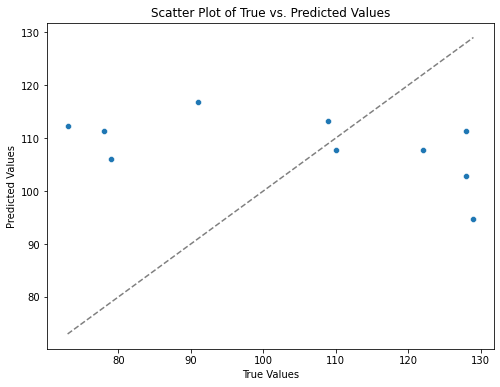

In [20]:
# Print data types and shapes for verification
print("real_array type:", type(real_array))
print("real_array shape:", real_array.shape)
print("pred_array type:", type(pred_array))
print("pred_array shape:", pred_array.shape)

# Scatter Plot with Regression Line
plt.figure(figsize=(8, 6))
sns.scatterplot(x=real_array, y=pred_array)
plt.plot([min(real_array), max(real_array)], [min(real_array), max(real_array)], linestyle='--', color='gray')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of True vs. Predicted Values')
plt.show()


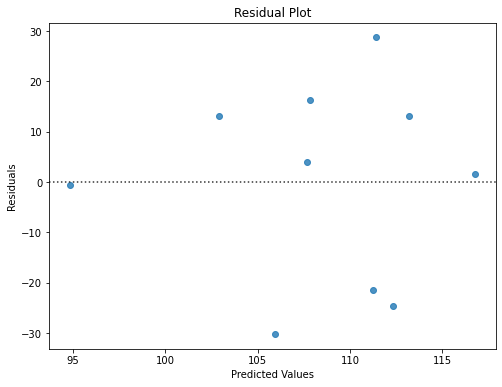

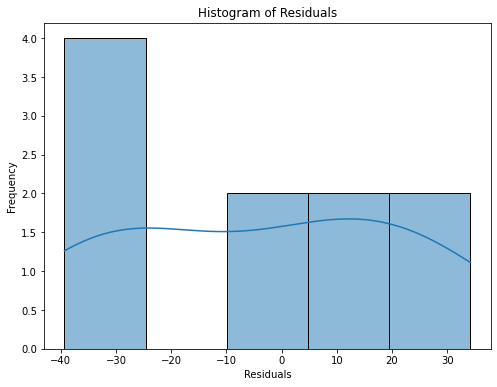

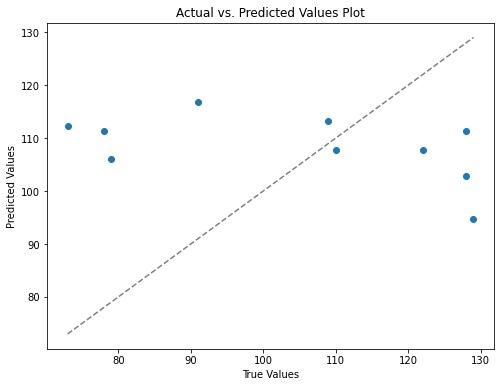

In [21]:
# Residual Plot
plt.figure(figsize=(8, 6))
sns.residplot(x=pred_array, y=real_array - pred_array)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(real_array - pred_array, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# Actual vs. Predicted Values Plot
plt.figure(figsize=(8, 6))
plt.plot(real_array, pred_array, 'o')
plt.plot([min(real_array), max(real_array)], [min(real_array), max(real_array)], linestyle='--', color='gray')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values Plot')
plt.show()

# Learning Curve - Replace this with your own model's learning curve
# ...

# Feature Importance Plot - Replace this with your own feature importance
# ...

# Confusion Matrix Heatmap (for Classification) - Replace this with your own confusion matrix
# ...


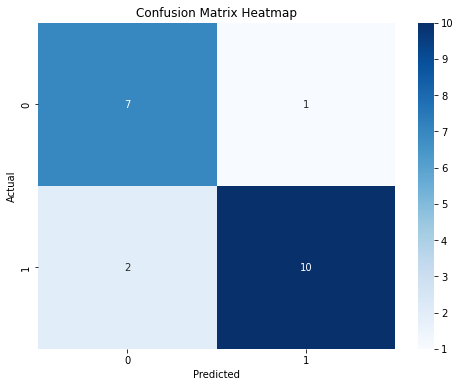

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Generate a synthetic classification dataset for demonstration
X, y = make_classification(n_samples=100, n_features=5, n_informative=3, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training (Logistic Regression) - Replace this with your own model
model = LogisticRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()
